# Classifying Crime: San Francisco Open Data
Crime data from 2003 to early 2015 has been published by the city/county of San Francisco (herein SF) by SF Opendata. Using indicators of time, location, and responding police districts, the task was to classify a reported crime.

## Useful Libraries, Scripts, and Other Imports

In [189]:
import crime
reload(crime)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

## Loading the Data - Cleaning and Recoding

We first load and clean the data - replacing extraneous or erroneous longitude and latitude values with median locations based upon responding police district, breaking the timestamps into individual columns, turning category labels into category numbers to improve the performance of future models, and dropping redundant columns that were otherwise recoded.

In [13]:
train = crime.load_cleaned_train()
test = crime.load_cleaned_test()

# print train.info()
# print test.info()

During exploration, it was found that mapping crimes yielded a gridded type pattern when overlayed with the a map of San Francisco. Upon further inspection of the address column, we decided to add a flag to the data which captures whether or not a crime occured on a street corner. Further, we also measured across all years the most prevalent address locations on which crimes were reported, and encode the top two streets reported. The first street - the street on which most reports are addressed - turns out to be the street on which the courthouse is located within the city. Below, see an example of some crimes which are mapped. Note the number of crimes which appear to occur on a corner.

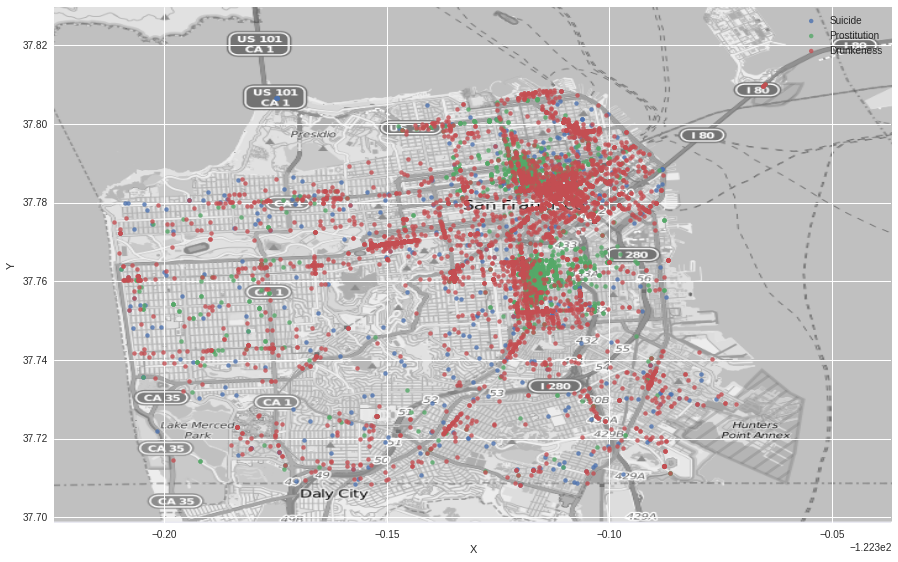

In [21]:
#Mapping an illustration of crime across all years to show the relative
#locations of interesting quantities, and the prevalence of 'corner crime'
#gridding.

#define plot information
plt.figure(figsize=(15,15))
plt.axis([-122.52469, -122.33663, 37.69862, 37.82986])

#get the map, downloaded to the working directory
mapdata = np.loadtxt('sf_map_copyright_openstreetmap_contributors.txt')
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

#map suicide, prostitution, and drunkenness
ax = sns.regplot(train[train.Category == 'SUICIDE'].X, train[train.Category == 'SUICIDE'].Y, fit_reg=False)
ax = sns.regplot(train[train.Category == 'PROSTITUTION'].X, train[train.Category == 'PROSTITUTION'].Y, fit_reg=False)
ax = sns.regplot(train[train.Category == 'DRUNKENNESS'].X, train[train.Category == 'DRUNKENNESS'].Y, fit_reg=False)

#display the plot
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
plt.legend(['Suicide', 'Prostitution', 'Drunkeness'])
plt.show()

## More Closely Examining SF Crime
With the emergence of SF as a technology haven within the last 12 years, crime has changed character and flavor within the city. The changing face of the SF population has brough with it a due amount of unrest. To explore how this manifested within the dataset, we look at the spatial, temporal, and the spatiotemportal relationships.

### Temporal

HYPOTHESIS: The major types of crime have likely stayed the same, but the most significant crimes today are different from those in the early 2000s.

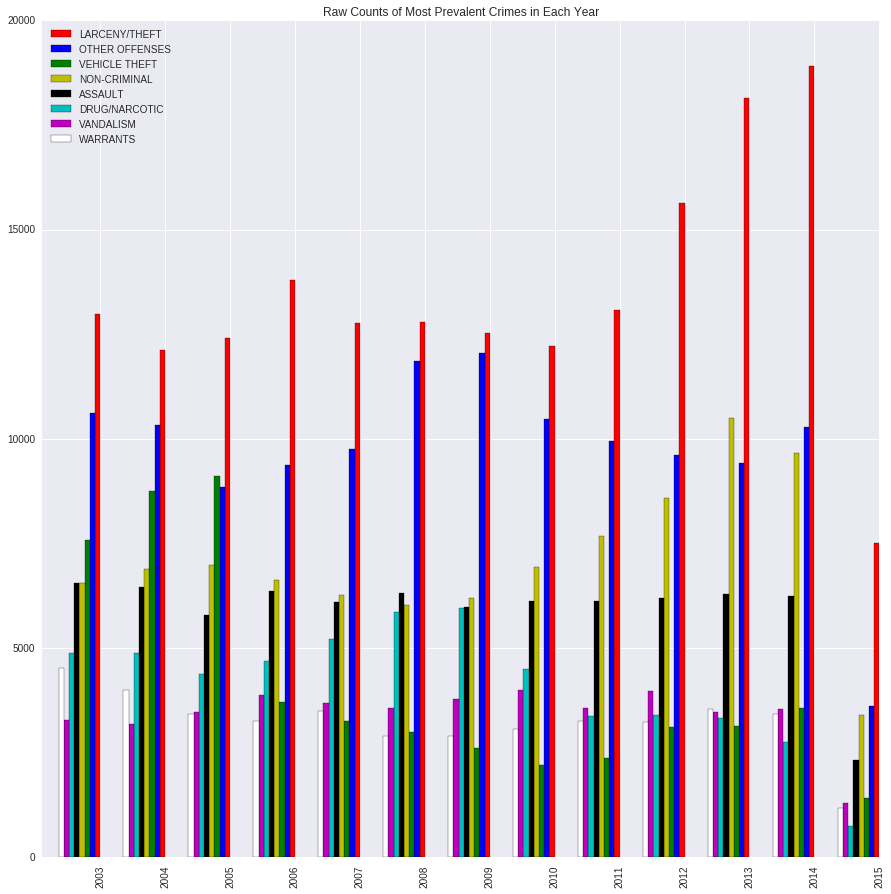

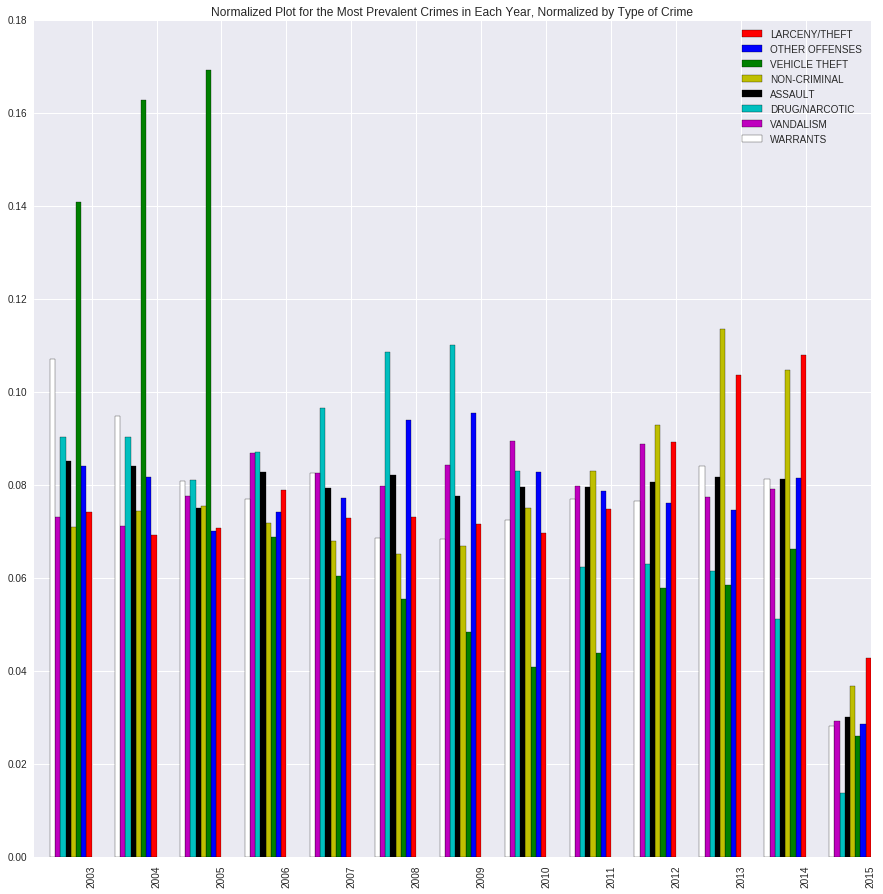

In [113]:
#set up for plotting, let's identify the top crimes in each year
count = 0
top_crime = []
colors = ['r','b','g','y','k','c','m','w','r','b','g','y','k','c','m','w'] #to make sure cover all crimes
years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
for year in years:
    cats = train.Category[train.Year==year].value_counts()[0:5]
    for category in cats.index:
        if category not in top_crime:
            top_crime.append(category)

#raw counts of those top crimes
plt.figure(figsize=(15,15))
for crime in top_crime:
    ax = train.Year[(train.Category==crime)].value_counts(sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime,loc='best')
plt.title('Raw Counts of Most Prevalent Crimes in Each Year')

#normalized counts across the years for each of those top crime
count = 0
plt.figure(figsize=(15,15))
for crime in top_crime:
    ax = train.Year[train.Category==crime].value_counts('normalize', sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime,loc='best')
plt.title('Normalized Plot for the Most Prevalent Crimes in Each Year, Normalized by Type of Crime')

TAKEAWAY: This hypothesis seems to hold true. There has been a rise in crime over the last several years, but the flavor of crime has shifted - there is proportionally more larceny and vehicle crime than there used to be, vehicle theft has plummetted, and the spike in drugs and narcotics is no longer evident.

Similarly, we wonder whether the time of the year holds any meaning to the types of crime which might be evident. Over the course of the months:

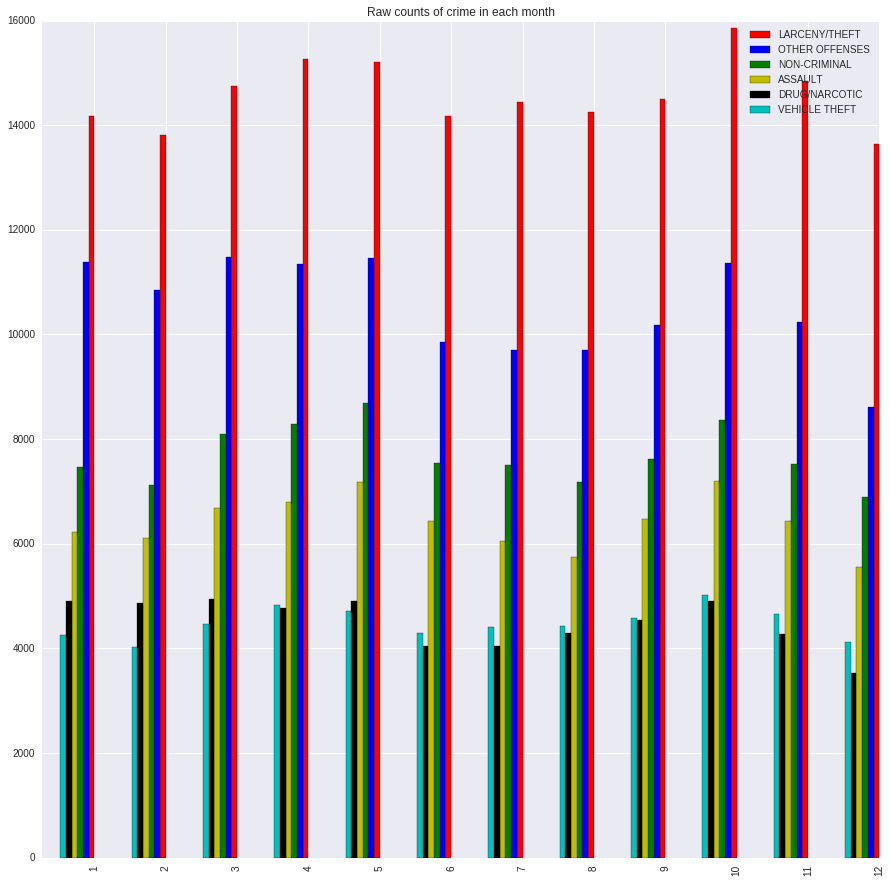

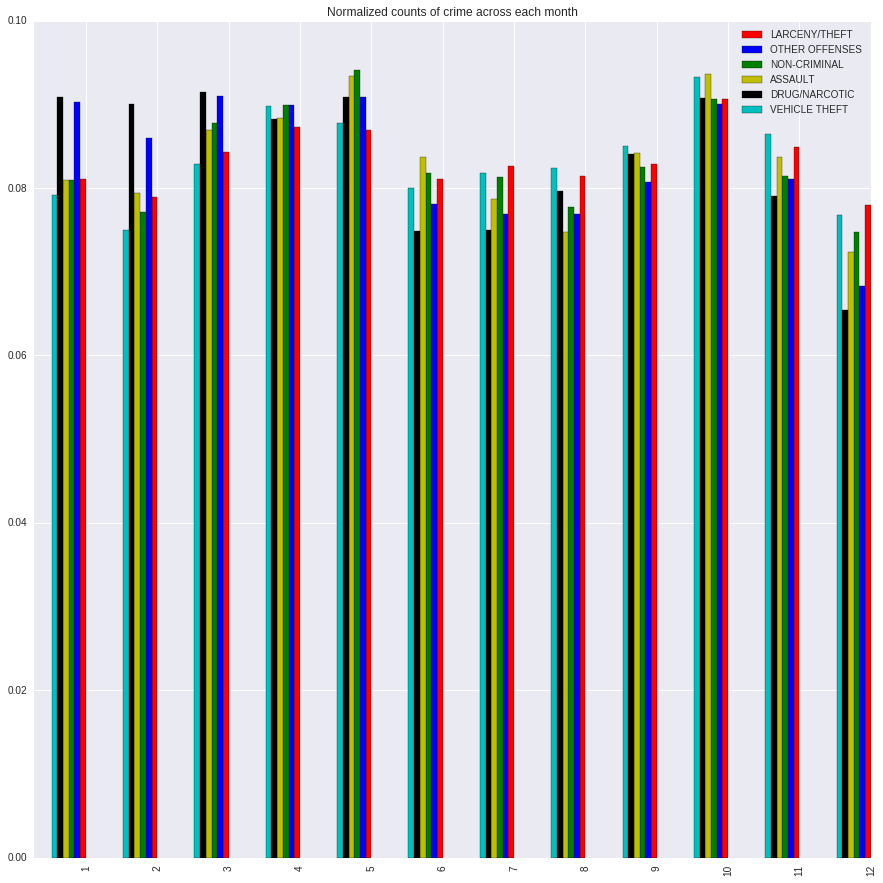

In [116]:
#taking a look at crime in each month
count = 0
top_crime = []
colors = ['r','b','g','y','k','c','m','w','r','b','g','y','k','c','m','w']
for month in train.Month.unique():
    cats = train.Category[train.Month==month].value_counts()[0:5]
    for category in cats.index:
        if category not in top_crime:
            top_crime.append(category)

plt.figure(figsize=(15,15))
for crime in top_crime:
    train.Month[train.Category==crime].value_counts(sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime,loc='best')
plt.title('Raw counts of crime in each month')

plt.figure(figsize=(15,15))
count = 0
for crime in top_crime:
    train.Month[train.Category==crime].value_counts('normalize',sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime,loc='best')
plt.title('Normalized counts of crime across each month')

Seasonal effects seem to be low, at best with spring and fall seemingly more crime-filled than other seasons. When looking at San Francisco weather patterns, we might be able to claim that given the moderate climate, crime may not be dissuaded from particularly bad weather. Though one might think that tourist season may see a general rise in crime, this does not necessarily seem to be the case as evidenced in the data. Some reasons for this might include a heightened police presence during these months, more temporary job vacancies, etc. When planning for temporal predictors, there does appear to be some signal in crime and months/years - these may be used in the final model.

HYPOTHESIS: Though seasonal changes might not appear significant, what about day to day? Certain types of crime will be more likely to be reported at unique times of day which may be mapped to either the time of crime discovery, or the time at which the perpetrator may have been caught.

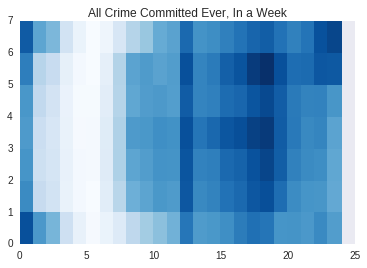

In [123]:
#report density plot for all crime reports as a function of day of week (1-7) and time of day (0-24)
grouped = train.groupby(['DoW', 'Hour']).Category.count()
data=grouped.values
test=data.reshape(7,24)
columns = train['Hour'].unique()
rows = train['DoW'].unique()
plt.pcolor(test,cmap=plt.cm.Blues)
plt.title('All Crime Committed Ever, In a Week')
plt.show()

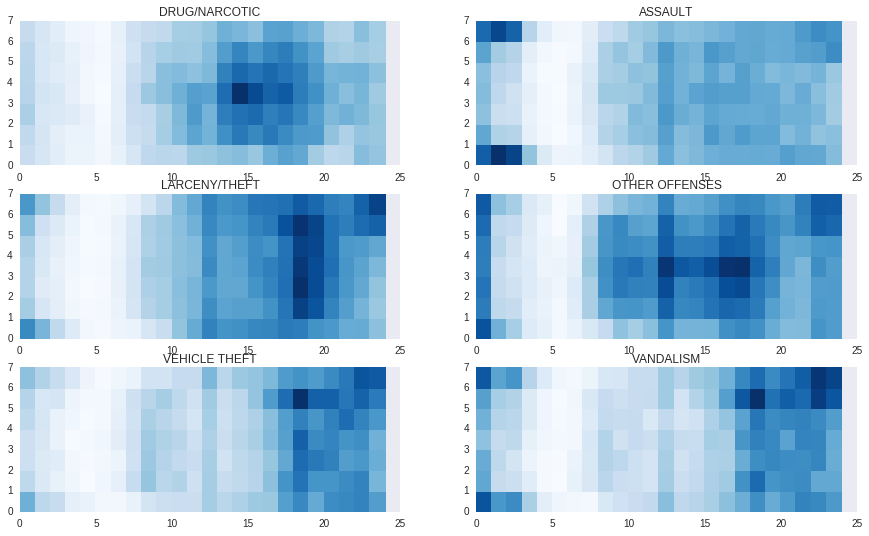

In [158]:
# report density plots for a variety of crimes
time_dep_hyp = ['DRUG/NARCOTIC', 'ASSAULT', 'LARCENY/THEFT', 'OTHER OFFENSES', 'VEHICLE THEFT', 'VANDALISM']
index = 521
plt.figure(figsize=(15,15))
for crime in time_dep_hyp:
    grouped = train[train.Category==crime].groupby(['DoW', 'Hour']).Category.count()
    data=grouped.values
    try:
        test=data.reshape(7,24)
        columns = train['Hour'].unique()
        rows = train['DoW'].unique()
        plt.subplot(index)
        plt.pcolor(test,cmap=plt.cm.Blues)
        plt.title(crime)
    except:
        pass
    index += 1

TAKEAWAY: There does seem to be a strong relationship between time of day and the type of crime, with a secondary day of week relationship. It certainly seems like 5AM is a low point in crime reports, with midday, early evening, or midnight being a secondary peak in the day.

### Spatial
Now, let's look at some of those spatial relationships...

HYPOTHESIS: Different types of crime will localize in unique, dense, areas.

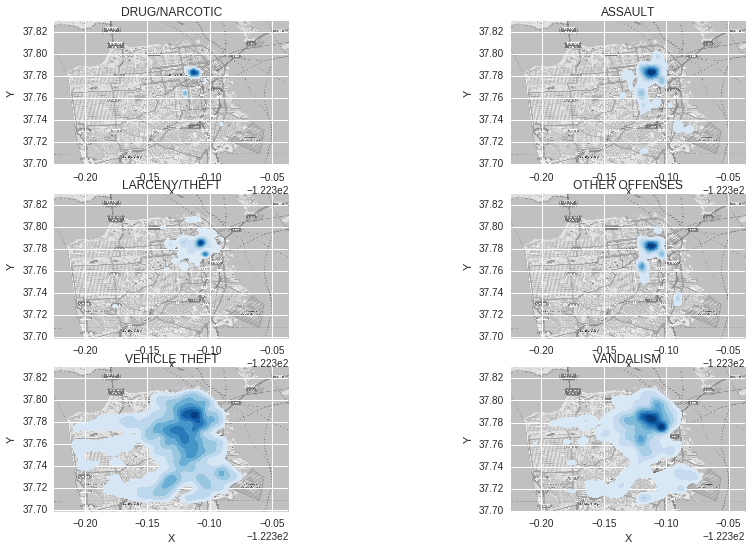

In [188]:
#Density maps of crime types
mapdata = np.loadtxt('sf_map_copyright_openstreetmap_contributors.txt')
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

index = 521
color = 'Blues'
plt.figure(figsize=(15,15))
for crime in time_dep_hyp:
    plt.axis([-122.52469, -122.33663, 37.69862, 37.82986])
    crime2plot = train.loc[train.Category == crime]
    plt.subplot(index)
    sns.kdeplot(crime2plot.X, crime2plot.Y, shade=True, shade_lowest=False, cmap=color, legend=True)
    plt.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
    plt.title(crime)
    index += 1
    

TAKEAWAY: Some of the crimes have a clear spatial relationship - and most crimes seem to concentrate within one particular area. The spread of crimes is also revealing - while other offenses happen just about everywhere, something like drug/narcotic crimes. Location will certainly factor into a model of interest.

### Spatiotemporal
Given that the face of crime has changed, and there is certainly a relationship between location and crime type, we determine whether these factos together may yield some interesting relationships which could be exploited in model predictors.

HYPOTHESIS: Some crime locations have shifted over time, though potentially minimally, whereas others may be relatively new or have completely died as gentrification, tourism, and the technology boom took over the city.

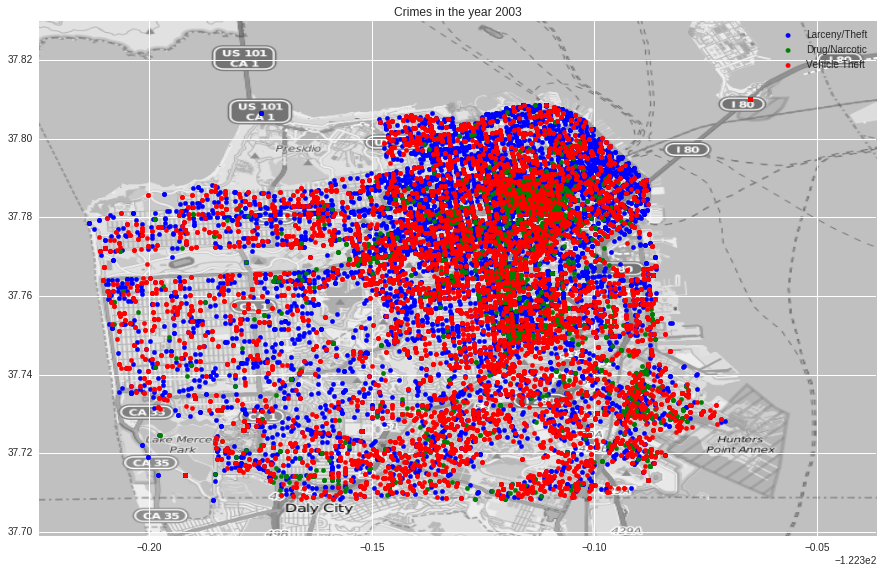

In [191]:
#Slider widget for crimes by year
def plotOnMap(df, color='b', fig=None):
    """
    Plot the given data frame on the map
    Unfortunately, the two 'if fig' statements can't be combined
    """
    if not fig:
        fig = plt.figure(figsize=(15,15))
    plt.scatter(df.X, df.Y, color=color)
    for ax in fig.axes:
        ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                  extent=lon_lat_box, 
                  aspect=asp)
    return fig

def plotByYear(year):
    """
    Plot crimes from the given year
    Unfortunately, seem to require (ab)using global variables
    """
    df = train[train.Year == year]
    f = plotOnMap(df[df.Category == 'LARCENY/THEFT'], 'b')
    plotOnMap(df[df.Category == 'DRUG/NARCOTIC'], 'g', f)
    plotOnMap(df[df.Category == 'VEHICLE THEFT'], 'r', f)
    plt.legend(['Larceny/Theft', 'Drug/Narcotic', 'Vehicle Theft'])
    plt.title('Crimes in the year {}'.format(year))

year_slider = widgets.IntSlider(min=train.Year.min(), max=train.Year.max(), value=train.Year.min())
widgets.interact(plotByYear, year=year_slider)

TAKEAWAY: This confirms both of the spatial and temporal pieces that have already been discussed, but also shows that there has been some mobility over time on crime, at least in these categories. Using spatial and temporal classifiers together will be critical to developing a robust model.

## Classifying Crime
Given the relationships which were discovered, or assumed, we want to develop a set of predictors which have demonstrable relationships with crime types in order to test and train our model. The three model types which seem to be appropriate given the type of data being used are the Logistic Regression, Random Forest, and K Nearest Neighbors.